In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import seaborn as sb
import os
import healpy as hp

In [3]:
from lsst.sims.photUtils import noiseUtilities
from lsst.sims.photUtils import Bandpass, Photometry#, PhotometryBase

In [5]:
engine = create_engine('sqlite:////Users/rbiswas/data/LSST/OpSimData/enigma_1189_sqlite.db')

In [6]:
Summary  = pd.read_sql_table('Summary', engine)
Proposal = pd.read_sql_table('Proposal', engine)
Seeing   = pd.read_sql_table('Seeing', engine)
Field    = pd.read_sql_table('Field', engine)

In [7]:
Summary.drop_duplicates('expMJD', inplace=True)

In [8]:
Summary.shape, Proposal.shape, Seeing.shape, Field.shape

((2469307, 45), (5, 6), (210384, 3), (5292, 8))

In [9]:
Summary.columns

Index([u'obsHistID', u'sessionID', u'propID', u'fieldID', u'fieldRA', u'fieldDec', u'filter', u'expDate', u'expMJD', u'night', u'visitTime', u'visitExpTime', u'finRank', u'finSeeing', u'transparency', u'airmass', u'vSkyBright', u'filtSkyBrightness', u'rotSkyPos', u'lst', u'altitude', u'azimuth', u'dist2Moon', u'solarElong', u'moonRA', u'moonDec', u'moonAlt', u'moonAZ', u'moonPhase', u'sunAlt', u'sunAz', u'phaseAngle', u'rScatter', u'mieScatter', u'moonIllum', u'moonBright', u'darkBright', u'rawSeeing', u'wind', u'humidity', u'slewDist', u'slewTime', u'fiveSigmaDepth', u'ditheredRA', u'ditheredDec'], dtype='object')

In [10]:
# Read in LSST bandpasses.
bpdir = os.getenv("LSST_THROUGHPUTS_BASELINE")
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
lsstbp = {}
for f in filterlist:
    lsstbp[f] = Bandpass()
    lsstbp[f].readThroughput(os.path.join(bpdir, 'total_'+f+'.dat'))
#dt, t = dtime(t)

In [13]:
lsstbp['g'].sb

array([  1.18805065e-08,   1.40275873e-08,   1.63586274e-08, ...,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [15]:
from lsst.sims.photUtils.SignalToNoise import calcGamma

In [19]:
from lsst.sims.photUtils.PhotometricParameters import PhotometricParameters

In [20]:
phot = PhotometricParameters()

In [25]:
gamm = lambda x: calcGamma(bandpass=lsstbp[x[0]], m5=x[1], photParams=phot)

In [29]:
Summary.ix[0]

obsHistID           1
sessionID        1189
propID            364
fieldID           316
fieldRA      1.676483
Name: 0, dtype: object

In [30]:
# Add gamma to dataframe
Summary['gamma'] = Summary[['filter','fiveSigmaDepth']].apply(lambda x:
                                                    calcGamma(bandpass=lsstbp[x[0]], m5=x[1], photParams=phot), 
                                                    axis=1)

In [31]:
Summary['N0sq'] = Summary['gamma'] * 10.0 **(-0.2 * Summary['fiveSigmaDepth'])
Summary['alpha'] = Summary['gamma'] 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b674cd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1822a9410>]], dtype=object)

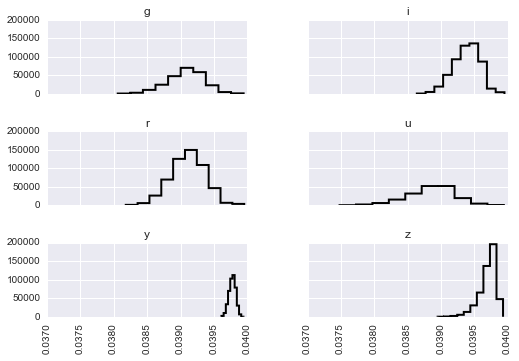

In [32]:
Summary['alpha'].hist(by=Summary['filter'], histtype='step', lw=2.0, color='k', sharex=True, sharey=True)

In [ ]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True)
Summary['gamma'].hist(by=Summary['filter'], histtype='step', lw=2., color='k', normed=1, bins=20, ax=ax)

In [41]:
Summary.to_hdf('new_storage.h5', 'table')

/usr/local/manual/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:2558: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  warnings.warn(ws, PerformanceWarning)
/usr/local/manual/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:2558: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_items] [items->None]

  warnings.warn(ws, PerformanceWarning)
/usr/local/manual/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:2558: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block1_items] [items->None]

  warnings.warn(ws, PerformanceWarning)
/usr/local/manual/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:2558: Performanc

## Scratch

In [131]:
fs = Summary.groupby('filter')

In [132]:
fs.groups.keys()

[u'g', u'i', u'r', u'u', u'y', u'z']

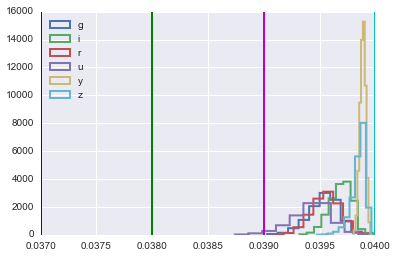

In [205]:
fig, ax  = plt.subplots()
zip (fs.groups.keys(), map(lambda x: fs.get_group(x)['gamma'].hist(histtype='step', lw=2, normed=1, label=x, ax=ax), fs.groups.keys()))
ax.legend(loc='best')
ax.axvline(0.037, lw=2., color='b')
ax.axvline(0.038, lw=2., color='g')
ax.axvline(0.039, lw=2., color='r')
ax.axvline(0.039, lw=2., color='m')
ax.axvline(0.040, lw=2., color='y')
ax.axvline(0.040, lw=2., color='c')

In [206]:
fig.savefig('Gamma_paperVals_hist.pdf')